# Find the central star of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 24th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

FindCentralStar_HD14943


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [15]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [16]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [17]:
inputdir="./reduced_fitsimages"      # Do not apply background subtraction, only reduction
#inputdir="./processed_fitsimages"   # Having applied background subtraction
object_name='HD14943'

### Output directory fot fits images

In [18]:
outputdir="./cut_fitsimages"

In [19]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [20]:
input_filelist=os.listdir(inputdir) 

In [21]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [22]:
print input_filelist[:5]

['reduced_HD14943_20170118_235.fits' 'reduced_HD14943_20170118_237.fits'
 'reduced_HD14943_20170118_239.fits' 'reduced_HD14943_20170118_241.fits'
 'reduced_HD14943_20170118_243.fits']


In [23]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [24]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
#                num_str=re.findall('^imgbkgsub_HD14943_20170117_([0-9]+).fits',file)[0] #### SELECT
                num_str=re.findall('^reduced_HD14943_20170118_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [25]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [26]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [27]:
print indexes_files

[235 237 239 241 243]


In [28]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [29]:
sorted_numbers=indexes_files[sorted_indexes]

In [30]:
print sorted_indexes

[0 1 2 3 4]


In [31]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [32]:
#sorted_files

## Build full filename
----------------------------

In [33]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [34]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [35]:
print sorted_filenames.shape

(5,)


## Acces to data of  images
----------------------------------

In [36]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [37]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header

In [38]:
all_dates,all_airmass,all_images,all_titles,all_header=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [39]:
len(all_images)

5

In [40]:
%%cython

import numpy as np
import matplotlib.pyplot as plt
import os    

def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """

    #global dir_top_images
    
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    

    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=100)
        axarr[iy,ix].set_title(all_titles[index])
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16) 
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

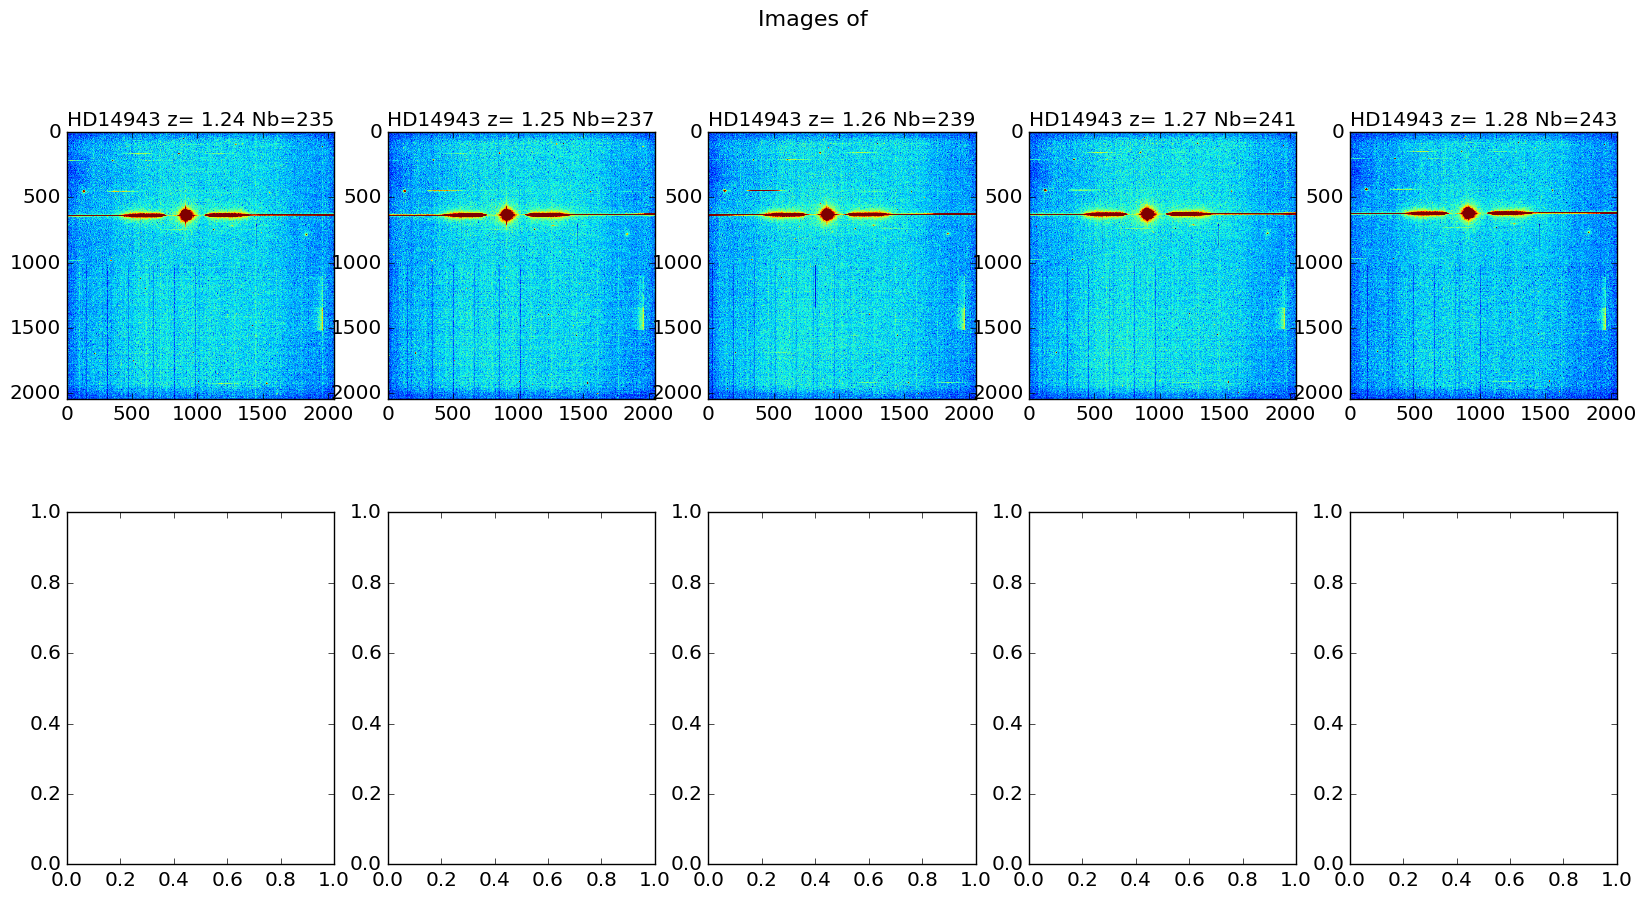

In [41]:
ShowImages(all_images,all_titles,object_name,dir_top_images)

### Find the star locations
----------------------------

In [42]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=3.0, threshold=1000.*std)
        img_sources.append(sources)      
    return img_mean,img_median,img_std,img_sources

In [43]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

In [44]:
sel=3

In [45]:
thesource=img_sources[sel]
img_size=all_images[sel].shape

In [46]:
print thesource

 id   xcentroid     ycentroid   ...      peak          flux           mag      
--- ------------- ------------- ... ------------- ------------- ---------------
  1 123.339491745 451.502667303 ...  17247.877158 1.22120063858 -0.216967556813
  2 902.218329514 616.472676032 ... 58348.0296129 3.01878700045  -1.19958117789
  3 901.814070184 624.563154198 ... 59382.2838245 2.97472703071  -1.18361779954
  4 901.162331248 627.666023217 ... 59984.2514661 2.97884460756  -1.18511962172
  5 900.423135755 631.208399625 ... 59543.5001012 2.07110684174 -0.790506258319
  6 904.388168409 635.567187758 ... 58052.4818115 1.64717897869 -0.541851977943
  7 903.401602182 637.068926894 ... 58275.3673659 2.25177055201  -0.88131033815
  8 901.171498665 643.384369329 ... 58153.8151431 2.99495810222  -1.19097687808
  9 901.796516715 645.457434943 ... 58875.7566512 3.01643687733    -1.198735604
 10 902.126724632 650.512066822 ... 58854.8328399 2.86028712527  -1.14102407816
 11 273.004692328 1827.93421376 ... 4008

In [47]:
x_star=thesource["xcentroid"]
y_star=thesource["ycentroid"]
points_set=np.array(zip(x_star,y_star))

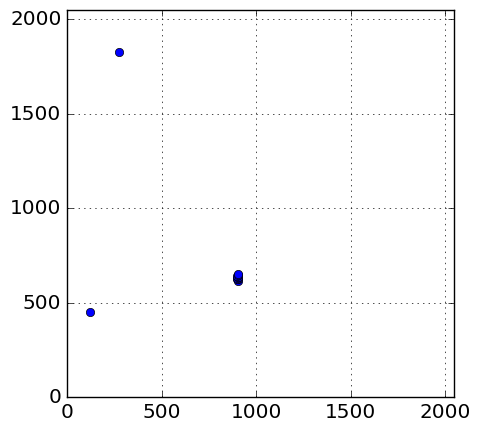

In [48]:
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Search the main central star
----------------------------------

In [49]:
%%cython
import numpy as np

"""
Set of routine to find the right position of the main central star
"""
def distance(v1,v2): 
    return sum([(x-y)**2 for (x,y) in zip(v1,v2)])**(0.5)

def GetDistanceSum(thepoint, points_set):
    """
    Return the distance sum of the point thepoit to the set of points points_set
    """
    dist_sum=0
    for otherpoint in points_set:
        dist= distance(thepoint,otherpoint)
        dist_sum+=dist
    return dist_sum

def GetAllDistanceSum(all_points):
    """
    Return the set of the distance sum to other point for all points
    """
    all_distances = []
    for thepoint in all_points:
        dist=GetDistanceSum(thepoint, all_points)
        all_distances.append(dist)
    all_distances=np.array(all_distances)
    return all_distances
        

def GetCentralPosition( x_star, y_star):
    """
    Find the position of the point which minimise the distance sum wrt other points
    """
    points_set=np.array(zip(x_star,y_star))
    distances_sum=GetAllDistanceSum(points_set)
    central_pos_index=np.where(distances_sum==distances_sum.min())[0][0]
    return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])

In [50]:
GetCentralPosition( x_star, y_star)

array([637, 903])

### Special way to find the right center of the main star

In [51]:
positions_central = []
for source in img_sources:
    x_star=source["xcentroid"]
    y_star=source["ycentroid"]
    position=GetCentralPosition(x_star,y_star)
    positions_central.append(position)

### Cut the image
------------------

In [52]:
DeltaY=200
DeltaX=600

In [53]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
        
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=theimage[y0-DeltaY:y0+DeltaY,:]
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,vmin=-10,vmax=200,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        #aperture.plot(color='red', lw=5.)
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

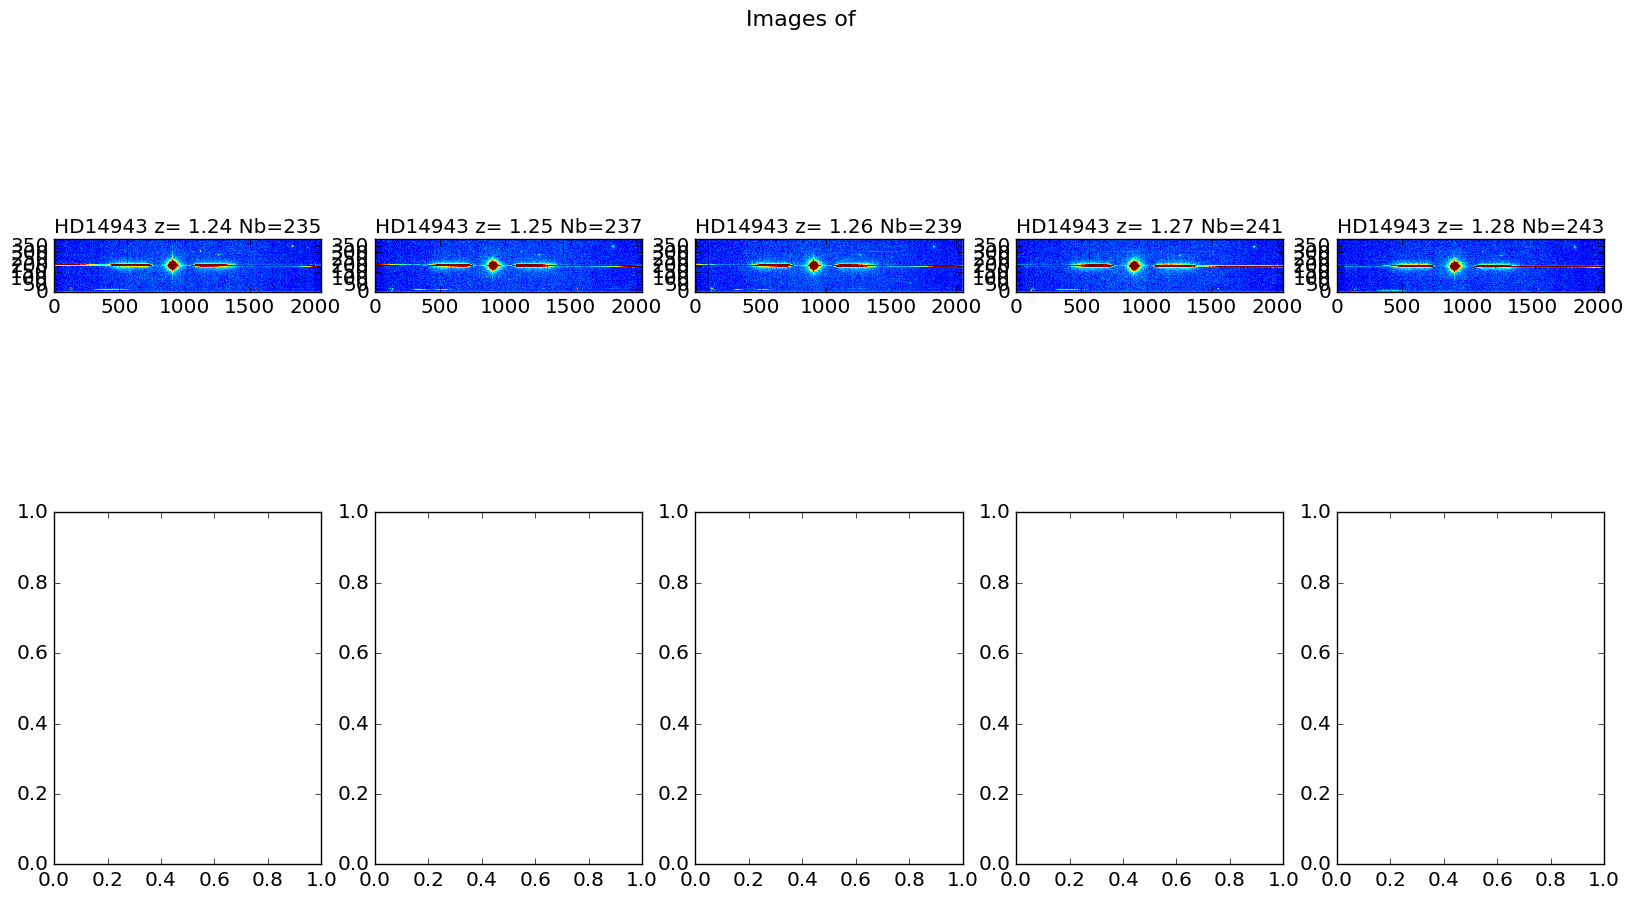

In [54]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [55]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [56]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [57]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

201


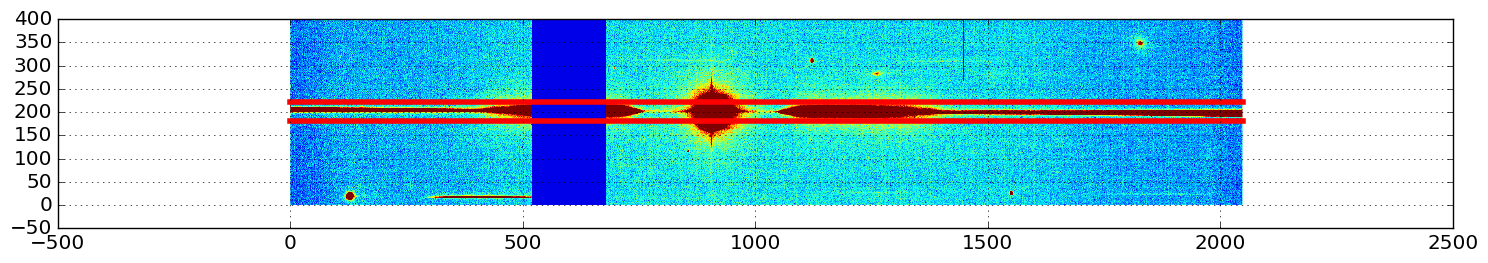

In [58]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=100,origin='lower',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=4)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=4)
plt.grid(True)
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

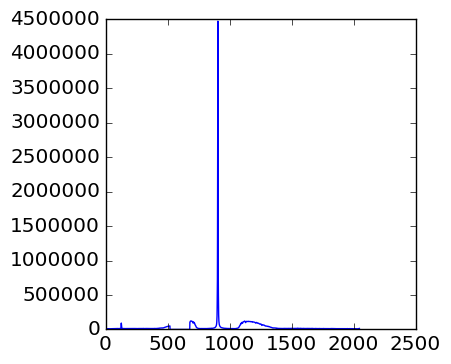

In [59]:
plt.plot(xprofile)

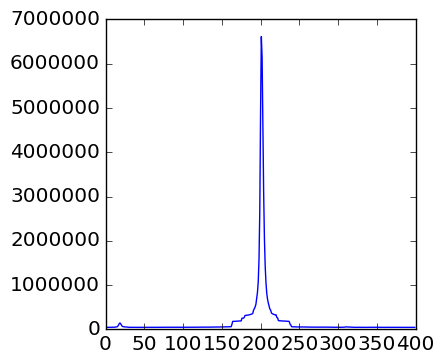

In [60]:
plt.plot(yprofile)

### Test rotation optimum
----------------------------

In [61]:
from scipy import stats 
from scipy import ndimage

In [62]:
RotationAngleOptimisation=False

In [63]:
rotation_angle_test=np.linspace(-5,5,100)
NBTESTS=rotation_angle_test.shape[0]
flux=np.zeros(NBTESTS)

In [64]:
if RotationAngleOptimisation:
    for index,angle in np.ndenumerate(rotation_angle_test):
        rotated_image=ndimage.interpolation.rotate(data,angle)
        imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
        region=rotated_image[imax-w: imax+w,0:rotated_image.shape[1]]  # extract the region
        imax2,jmax2 = np.unravel_index(region.argmax(), region.shape)
        #region[:,jmax2-ws:jmax2+ws]=0 # suppress central star
        flux[index]=region.sum()
        #print 'index = {} angle={:2.4f} flux = {:2.0f}'.format(index,angle,flux[index])

In [65]:
if RotationAngleOptimisation:
    plt.plot(rotation_angle_test,flux)

In [66]:
if RotationAngleOptimisation:
    dflux=flux.max()-flux
    plt.plot(rotation_angle_test,dflux)

### prepare outputfilename

In [67]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    #short_partfilename=re.findall('^imgbkgsub_(.*)',short_infilename)  #### SELECT
    short_partfilename=re.findall('^reduced_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

### Save outputfilename

In [68]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [69]:
 !ls -l cut_fitsimages

total 64160
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jan 26 15:17 cutimg_HD14943_20170118_235.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jan 26 15:17 cutimg_HD14943_20170118_237.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jan 26 15:17 cutimg_HD14943_20170118_239.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jan 26 15:17 cutimg_HD14943_20170118_241.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jan 26 15:17 cutimg_HD14943_20170118_243.fits


In [70]:
newfullfilenames

['./cut_fitsimages/cutimg_HD14943_20170118_235.fits',
 './cut_fitsimages/cutimg_HD14943_20170118_237.fits',
 './cut_fitsimages/cutimg_HD14943_20170118_239.fits',
 './cut_fitsimages/cutimg_HD14943_20170118_241.fits',
 './cut_fitsimages/cutimg_HD14943_20170118_243.fits']